# HW1 Food Image Classification

# Get Data
Google Dirve (檔案很大，請盡量先用Kaggle): https://drive.google.com/file/d/1yNYrS3oyRHBcAo6dtelNyAUnF4qI15b9/view?usp=sharing



# 訓練模型
1. 環境: anaconda3 
2. Python: 3.7.16 
3. 模型架構: Tensorflow.keras
4. Cuda_toolkit: 11.3.1
5. CuDNN: 8.4.1

## 匯入所需python package

In [1]:
_exp_name = "10_tf_cnn"
# Import necessary packages
# pip install numpy pandas torch torchvision tqdm
# pip install --upgrade jupyter
import numpy as np
import pandas as pd
import os
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

## 定義讀取檔案

In [2]:
def readfile(path, label):
    image_dir = sorted(os.listdir(path)) # 將路徑上所有資料進行排序
    x = np.zeros((len(image_dir), 128, 128, 3), dtype=np.uint8) # 宣告儲存圖片的np.array
    y = np.zeros((len(image_dir)), dtype=np.uint8) # 宣告儲存圖片標籤的np.array
    Z = [] # 回傳檔名
    for i, file in enumerate(image_dir): 
        img = cv2.imread(os.path.join(path, file)) # 用cv2讀取圖片
        x[i, :, :, :] = cv2.resize(img,(128, 128)) # Resize圖片並儲存在x
        
        # If label is True, 從檔名抽取標籤
        if label:
            y[i] = int(file.split("_")[0])
            Z.append(file)
        print(f"reading data:{i+1}/{len(image_dir)}", end="\r")
            
    # If label is True, 回傳x和y; 否則, 只回傳x
    if label:
        return x, y, Z # for training
    else:
        return x    # for testing


## 讀取檔案&&分層抽樣

In [ ]:
workspace_dir = 'C:\\Users\\HCX\\Downloads\\HW01\\Dataset'
X, y, Z= readfile(os.path.join(workspace_dir, "training"), True)
# 每個標籤抽8成數據當成訓練集, 剩餘2成當驗證集
train_x, val_x, train_y, val_y = train_test_split(X, y, test_size = 0.20, random_state = 891010)

# 打印訓練集和驗證集大小
print(f"Size of training data = {len(train_x)}")
print(f"Size of validation data = {len(val_x)}")

## 資料增強(增加訓練資料的多樣性)

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation((-0.45,0.45)),
  # layers.experimental.preprocessing.RandomContrast(factor=(0.2,0.5)), # 添加後訓練效果不好
])

test_copy = train_x.copy()
label_copy = train_y.copy()
for i in range(len(test_copy)):
  print(f"data augmentation:{i+1}/{len(test_copy)}", end="\r")
  image = tf.cast(tf.expand_dims(test_copy[i], 0), tf.float32)
  for j in range(1):
    augmented_image = data_augmentation(image)
    train_x = np.concatenate((train_x, augmented_image.numpy().astype("uint8")))
    train_y = np.append(train_y, label_copy[i])
    
# 儲存增強後的圖片的目錄
output_dir = "augmented_images"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
for i in range(len(train_x)):
    cv2.imwrite(os.path.join(output_dir, f'{train_y[i]}_{i}.jpg'), train_x[i])
# 儲存增強後的圖片的目錄
output_dir_val = "val_images"
if not os.path.exists(output_dir_val):
    os.makedirs(output_dir_val)
for j in range(len(val_x)):
    cv2.imwrite(os.path.join(output_dir_val, f'{val_y[j]}_{j}.jpg'), val_x[j])

## 讀取已經儲存的圖片(為了方便, 上面就不用跑了)

In [3]:
workspace_dir = 'C:\\Users\\HCX\\Downloads\\HW01'
train_x, train_y, train_z= readfile(os.path.join(workspace_dir, "augmented_images"), True)
val_x, val_y, val_z = readfile(os.path.join(workspace_dir, "val_images"), True)
print(f'{len(train_x)}{train_x.shape}{len(train_y)}{train_y.shape}{len(val_x)}{val_x.shape}{len(val_y)}{val_y.shape}')

15784(15784, 128, 128, 3)15784(15784,)1974(1974, 128, 128, 3)1974(1974,)


## 為了retrain model 將訓練集再度拆分

In [ ]:
train_set, another_train_set, train_label, another_train_label = train_test_split(train_x, train_y, test_size = 0.30, random_state = 891010)

In [ ]:
# 檢驗訓練集和驗證集的標籤
train_list = np.zeros(11)
valid_list = np.zeros(11)
for i in range(len(train_label)):
    train_list[train_label[i]] = train_list[train_label[i]]+1
print("train list:{}".format(train_list))
for i in range(len(another_train_label)):
    valid_list[another_train_label[i]] = valid_list[another_train_label[i]]+1
print("valid list:{}".format(valid_list))

## 模型架構

In [7]:
input_shape = (128, 128, 3)

model = models.Sequential(name=f"my_{_exp_name}_model")
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))


model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))


model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(500, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(11, activation='softmax'))

model.summary()

Model: "my_10_tf_cnn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 128, 128, 64)      1792      
_________________________________________________________________
batch_normalization_30 (Batc (None, 128, 128, 64)      256       
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 128, 128, 64)      36928     
_________________________________________________________________
batch_normalization_31 (Batc (None, 128, 128, 64)      256       
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 128, 128, 64)      36928     
_________________________________________________________________
batch_normalization_32 (Batc (None, 128, 128, 64)      256       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 64, 64, 64) 

## 開始訓練

In [8]:
if tf.config.list_physical_devices('GPU'):
    device = '/device:GPU:0'
else:
    device = '/device:CPU:0'
print(device)

# 設置保存模型的路徑和條件
checkpoint_path = f"{_exp_name}_best.ckpt" # 儲存權重
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max', save_weights_only=True)

checkpoint_path_cp = f"{_exp_name}_best.h5" # 完整模型
checkpoint_cp = ModelCheckpoint(checkpoint_path_cp, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max', save_weights_only=False)

early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, verbose=2) # 提前終止


with tf.device(device):
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])

    history = model.fit(train_x, train_y, epochs=200, batch_size=30,
                        validation_data=(val_x, val_y), 
                        callbacks=[checkpoint, checkpoint_cp, early_stopping])

/device:GPU:0
Epoch 1/200
527/527 [==============================] - 147s 270ms/step - loss: 12.8236 - accuracy: 0.1965 - val_loss: 4.8514 - val_accuracy: 0.2579

Epoch 00001: val_accuracy improved from -inf to 0.25785, saving model to 10_tf_cnn_best.ckpt

Epoch 00001: val_accuracy improved from -inf to 0.25785, saving model to 10_tf_cnn_best.h5
Epoch 2/200
527/527 [==============================] - 138s 261ms/step - loss: 3.6943 - accuracy: 0.2647 - val_loss: 3.2224 - val_accuracy: 0.2614

Epoch 00002: val_accuracy improved from 0.25785 to 0.26140, saving model to 10_tf_cnn_best.ckpt

Epoch 00002: val_accuracy improved from 0.25785 to 0.26140, saving model to 10_tf_cnn_best.h5
Epoch 3/200
527/527 [==============================] - 139s 263ms/step - loss: 2.6234 - accuracy: 0.2997 - val_loss: 3.3922 - val_accuracy: 0.2077

Epoch 00003: val_accuracy did not improve from 0.26140

Epoch 00003: val_accuracy did not improve from 0.26140
Epoch 4/200
527/527 [==============================] -

## 繪製圖表

### acc plot

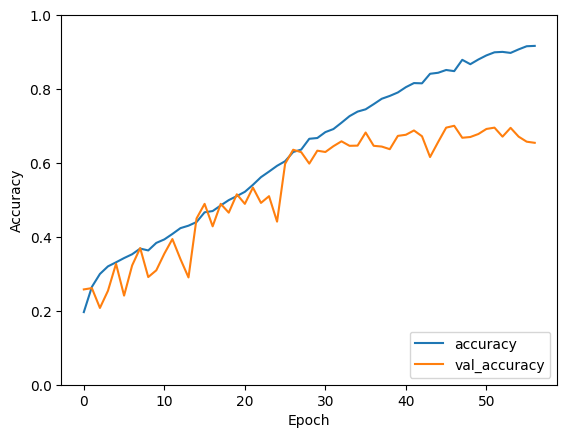

In [13]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.savefig(f'{_exp_name}_acc_plot.png', format='png')

### loss plot

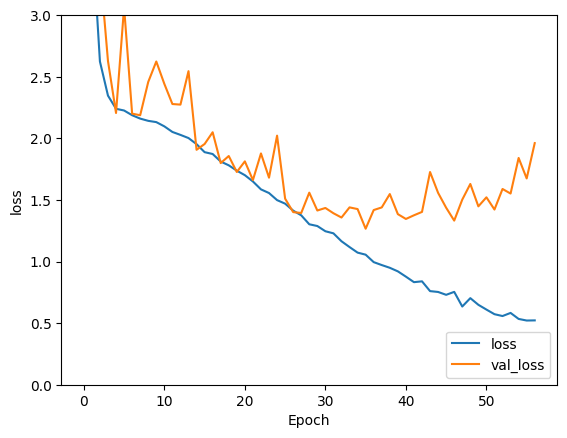

In [14]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.ylim([0, 3])
plt.legend(loc='lower right')
plt.savefig(f'{_exp_name}_loss_plot.png', format='png')

### 載入最佳模型

In [15]:
with tf.device('/device:GPU:0'):
    # 加載模型
    loaded_model = load_model(f'C:\\Users\\HCX\\Downloads\\HW01\\{_exp_name}_best.h5')
    predictions = loaded_model.predict(val_x)
    predicted_labels = np.argmax(predictions, axis=1)
    times = 0
    for i in range(len(val_x)):
        index = i
        classes = ['Bread', 'Dairy product', 'Dessert', 'Egg', 'Fried food', 'Meat', 'Noodles/Pasta', 'Rice', 'Seafood', 'Soup', 'Vegetable/Fruit']
        if val_y[index] == predicted_labels[index]:
            times += 1
        # else:
        #     rgb_img = cv2.cvtColor(val_x[index], cv2.COLOR_BGR2RGB)
        #     plt.imshow(rgb_img)# 显示图像
        #     plt.axis('off')  # 关闭坐标轴
        #     plt.show()
    print(f'acc {times/len(val_x)}')

acc 0.7006079027355623


### confusion metrix plot

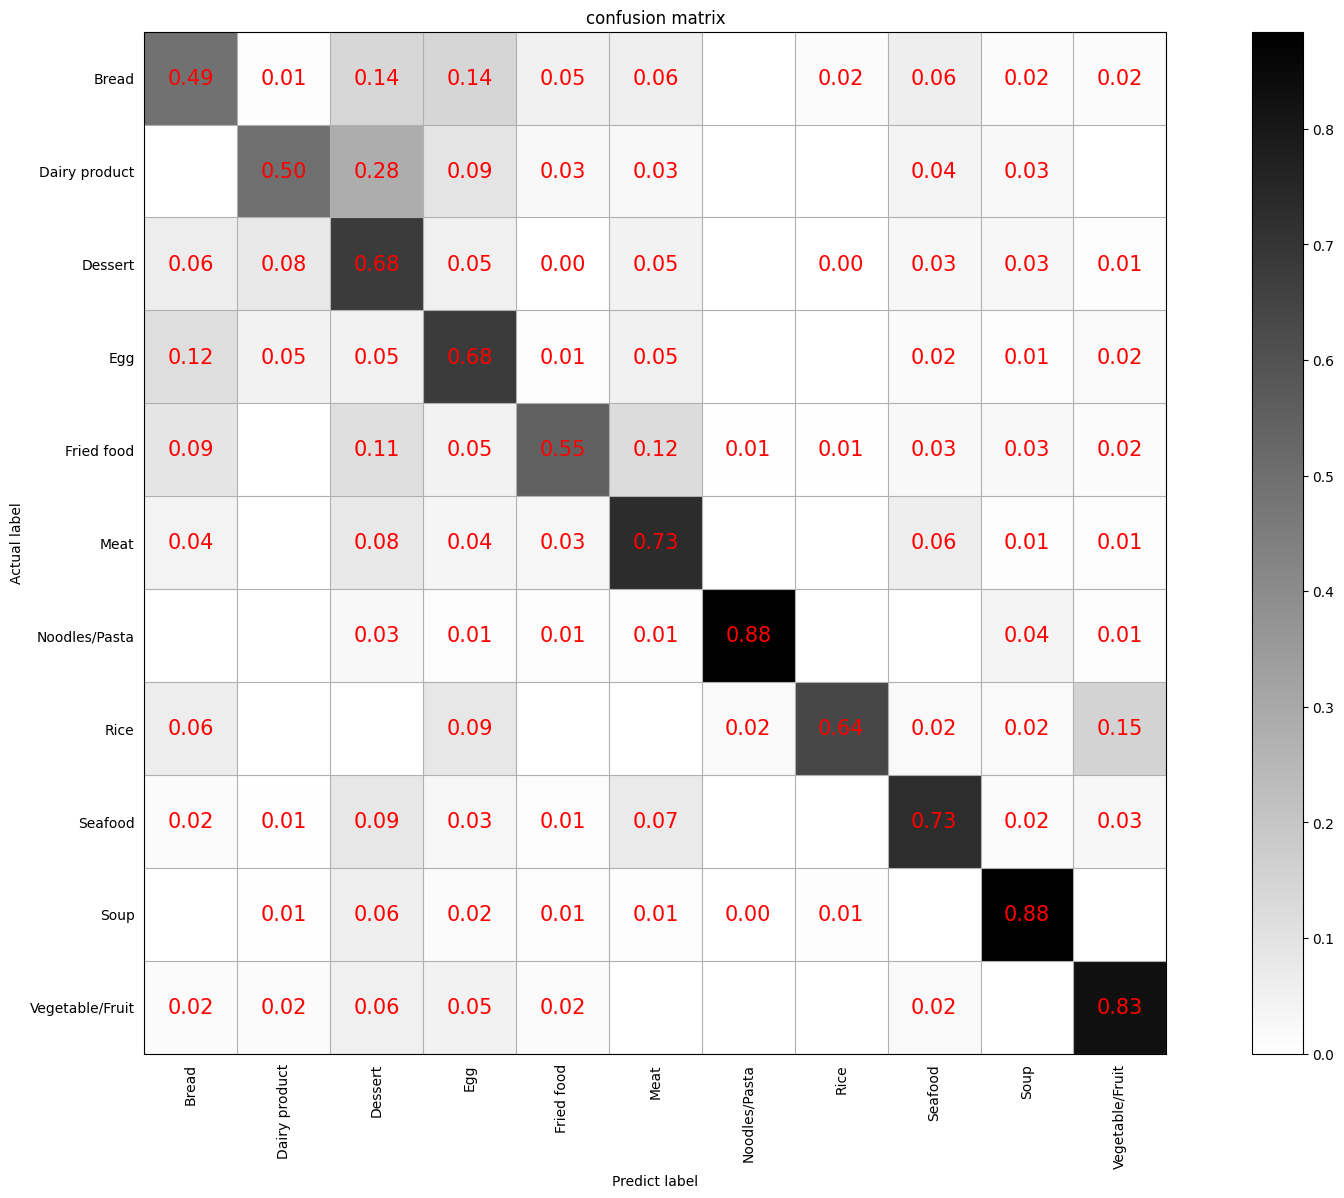

In [16]:
classes = ['Bread', 'Dairy product', 'Dessert', 'Egg', 'Fried food', 'Meat', 'Noodles/Pasta', 'Rice', 'Seafood', 'Soup', 'Vegetable/Fruit']
y_true = val_y.copy()  
y_pred = predicted_labels.copy()  
cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
def plot_confusion_matrix(cm, savename, title='Confusion Matrix'):

    plt.figure(figsize=(22, 14), dpi=100)
    np.set_printoptions(precision=2)

    ind_array = np.arange(len(classes))
    x, y = np.meshgrid(ind_array, ind_array)
    for x_val, y_val in zip(x.flatten(), y.flatten()):
        c = cm[y_val][x_val]
        if c > 0.001:
            plt.text(x_val, y_val, "%0.2f" % (c,), color='red', fontsize=15, va='center', ha='center')

    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.binary)
    plt.title(title)
    plt.colorbar()
    xlocations = np.array(range(len(classes)))
    plt.xticks(xlocations, classes, rotation=90)
    plt.yticks(xlocations, classes)
    plt.ylabel('Actual label')
    plt.xlabel('Predict label')

    # offset the tick
    tick_marks = np.array(range(len(classes))) + 0.5
    plt.gca().set_xticks(tick_marks, minor=True)
    plt.gca().set_yticks(tick_marks, minor=True)
    plt.gca().xaxis.set_ticks_position('none')
    plt.gca().yaxis.set_ticks_position('none')
    plt.grid(True, which='minor', linestyle='-')
    plt.gcf().subplots_adjust(bottom=0.15)

    # show confusion matrix
    plt.savefig(savename, format='png')
    plt.show()
plot_confusion_matrix(cm_normalized, f'{_exp_name}_confusion_matrix.png', title='confusion matrix')

## 建立預測標籤檔案

In [17]:
workspace_dir = 'C:\\Users\\HCX\\Downloads\\HW01\\Dataset'
test_set = readfile(os.path.join(workspace_dir, "testing"), False)
predictions_test = loaded_model.predict(test_set)
predicted_test_labels = np.argmax(predictions_test, axis=1)
#create test csv
def pad4(i):
    return "0"*(4-len(str(i)))+str(i)
df = pd.DataFrame()
df["Id"] = [pad4(i) for i in range(1,len(test_set)+1)]
df["Category"] = predicted_test_labels
df.to_csv(f"{_exp_name}_submission.csv",index = False)

# 再訓練模型(沒用到, 等待一批新的資料後再度啟用)

In [ ]:
if tf.config.list_physical_devices('GPU'):
    device = '/device:GPU:0'
else:
    device = '/device:CPU:0'
print(device)

# 設置保存模型的路徑和條件
checkpoint_path = f"re_{_exp_name}_best.ckpt" # 儲存權重
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max', save_weights_only=True)

checkpoint_path_cp = f"re_{_exp_name}_best.h5" # 完整模型
checkpoint_cp = ModelCheckpoint(checkpoint_path_cp, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max', save_weights_only=False)

early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, verbose=2) # 提前終止

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6) # 動態調整學習率

with tf.device(device):
    loaded_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                         loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                         metrics=['accuracy'])

    re_history = loaded_model.fit(train_set, train_label, epochs=200, batch_size=32,
                               validation_data=(val_x, val_y), 
                               callbacks=[checkpoint, checkpoint_cp, early_stopping, reduce_lr])


## acc plot

In [ ]:
plt.plot(re_history.history['accuracy'], label='accuracy')
plt.plot(re_history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.savefig(f're_{_exp_name}_acc_plot', format='png')

## loss plot

In [ ]:
plt.plot(re_history.history['loss'], label='loss')
plt.plot(re_history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.ylim([0, 3])
plt.legend(loc='lower right')
plt.savefig(f're_{_exp_name}_loss_plot', format='png')

## confusion matrix

In [ ]:
retrain_model = load_model(f'C:\\Users\\HCX\\Downloads\\HW01\\re_{_exp_name}_best.h5')
predictions = retrain_model.predict(val_x)
predicted_labels = np.argmax(predictions, axis=1)
classes = ['Bread', 'Dairy product', 'Dessert', 'Egg', 'Fried food', 'Meat', 'Noodles/Pasta', 'Rice', 'Seafood', 'Soup', 'Vegetable/Fruit']
y_true = val_y.copy()  
y_pred = predicted_labels.copy()  
cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
def plot_confusion_matrix(cm, savename, title='Confusion Matrix'):

    plt.figure(figsize=(22, 14), dpi=100)
    np.set_printoptions(precision=2)

    ind_array = np.arange(len(classes))
    x, y = np.meshgrid(ind_array, ind_array)
    for x_val, y_val in zip(x.flatten(), y.flatten()):
        c = cm[y_val][x_val]
        if c > 0.001:
            plt.text(x_val, y_val, "%0.2f" % (c,), color='red', fontsize=15, va='center', ha='center')

    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.binary)
    plt.title(title)
    plt.colorbar()
    xlocations = np.array(range(len(classes)))
    plt.xticks(xlocations, classes, rotation=90)
    plt.yticks(xlocations, classes)
    plt.ylabel('Actual label')
    plt.xlabel('Predict label')

    # offset the tick
    tick_marks = np.array(range(len(classes))) + 0.5
    plt.gca().set_xticks(tick_marks, minor=True)
    plt.gca().set_yticks(tick_marks, minor=True)
    plt.gca().xaxis.set_ticks_position('none')
    plt.gca().yaxis.set_ticks_position('none')
    plt.grid(True, which='minor', linestyle='-')
    plt.gcf().subplots_adjust(bottom=0.15)

    # show confusion matrix
    plt.savefig(savename, format='png')
    plt.show()
plot_confusion_matrix(cm_normalized, f're_{_exp_name}_confusion_matrix.png', title='confusion matrix')

## build test pridiction

In [ ]:
workspace_dir = 'C:\\Users\\HCX\\Downloads\\HW01\\Dataset'
test_set = readfile(os.path.join(workspace_dir, "testing"), False)
predictions_test = retrain_model.predict(test_set)
predicted_test_labels = np.argmax(predictions_test, axis=1)
#create test csv
def pad4(i):
    return "0"*(4-len(str(i)))+str(i)
df = pd.DataFrame()
df["Id"] = [pad4(i) for i in range(1,len(test_set)+1)]
df["Category"] = predicted_test_labels
df.to_csv(f"re_{_exp_name}_submission.csv",index = False)